# Project McNulty: Predicting Illegal Drugs Consumption
Elvis Davalillo - info@elvisdavalillo.com

Part 2/2 - Modeling

    1.Base Model
    2.Model Selection
    3.Complexity Reduction
    


In [2]:
# Start Python Imports
import math, time, random, datetime

# Data Wrangling
import numpy as np
import pandas as pd
import pickle
from collections import Counter

# Visualization
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import pydot
from mlxtend.plotting import plot_decision_regions

# Machine learning
from sklearn import model_selection, tree, preprocessing, metrics, linear_model
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.datasets import make_classification
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import LinearSVC, SVC
from imblearn.over_sampling import RandomOverSampler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import roc_auc_score,roc_curve,precision_score, recall_score, precision_recall_curve,f1_score
from sklearn.model_selection import cross_val_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import export_graphviz
import statsmodels.api as sm


warnings.filterwarnings('ignore')

Using TensorFlow backend.


In [5]:
df = pd.read_pickle('df.pkl')

## Base Model Selection: Train / Validation / Test with initial numerical features

In [ ]:
# let's start analyzing our target variable which is the consumption of illicit drugs in the last 12 months
df.groupby('ILLICIT').mean()

### Let's make a logistic regression our baseline model

In [311]:
#Separate our features from our target
X = df.loc[:,['CIGS','ALCOHOL','MARIJUANA','PAIN_REL','OXYCONTIN','TRANQUIL','HEAVY_ALC',
              'ARMY','PRIV_HEALTH','HEALTH','ARRESTED','NERVOUS','RESTLESS']]

y = df['ILLICIT']

In [312]:
# hold out 20% of the data for final testing
X, X_test, y, y_test = train_test_split(X, y, test_size=.2, random_state=10)

In [313]:
#further partition X, y into datasets X_train, y_train (60% of original) and X_val, y_val (20%).
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=.25, random_state=3)

In [314]:
print(X_train.shape, X_val.shape, X_test.shape)

(33765, 13) (11255, 13) (11256, 13)


In [315]:
#set up the baseline model:
lr = LogisticRegression() 

In [316]:
#fit
lr.fit(X_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)

In [11]:
#pickle for flask
pickle.dump(lr, open('my_pickled_model.p','wb'))

In [317]:
print("ROC train score: {:6.4f}".format(roc_auc_score(y_train,lr.predict_proba(X_train)[:,1])))
print("ROC validation score: {:6.4f}".format(roc_auc_score(y_val,lr.predict_proba(X_val)[:,1])))
print("ROC test score: {:6.4f}".format(roc_auc_score(y_test,lr.predict_proba(X_test)[:,1])))

ROC train score: 0.8669
ROC validation score: 0.8678
ROC test score: 0.8615


In [318]:
print("Precision test score: {:6.4f}".format(precision_score(y_test,lr.predict(X_test))))
print("Recall test score: {:6.4f}".format(recall_score(y_test,lr.predict(X_test))))
print("F1 test score: {:6.4f}".format(f1_score(y_test,lr.predict(X_test))))

Precision test score: 0.6233
Recall test score: 0.3090
F1 test score: 0.4132


In [323]:
pd.DataFrame(zip(['CIGS','ALCOHOL','MARIJUANA','PAIN_REL','OXYCONTIN','TRANQUIL','HEAVY_ALC',
              'ARMY','PRIV_HEALTH','HEALTH','ARRESTED','NERVOUS','RESTLESS'],*lr.coef_),columns =['Features','Coefficients']).\
            sort_values(by="Coefficients",ascending=False).reset_index(drop=True)

,Features,Coefficients
0,MARIJUANA,1.760603
1,TRANQUIL,1.185146
2,PAIN_REL,1.115117
3,OXYCONTIN,0.651755
4,HEAVY_ALC,0.644070
5,CIGS,0.619662
6,RESTLESS,0.407119
7,ARRESTED,0.316916
8,ALCOHOL,0.311871
9,PRIV_HEALTH,0.012793


In [319]:
def make_confusion_matrix(model, threshold=0.5):
    # Predict class 1 if probability of being in class 1 is greater than threshold
    # (model.predict(X_test) does this automatically with a threshold of 0.5)
    y_predict = (model.predict_proba(X_test)[:, 1] >= threshold)
    illicit_confusion = confusion_matrix(y_test, y_predict)
    plt.figure(dpi=80)
    sns.heatmap(illicit_confusion, cmap=plt.cm.Greens, annot=True, square=True, fmt='d',
           xticklabels=['no-illicit', 'illicit'],
           yticklabels=['no-illicit', 'illicit']);
    plt.xlabel('prediction')
    plt.ylabel('actual')

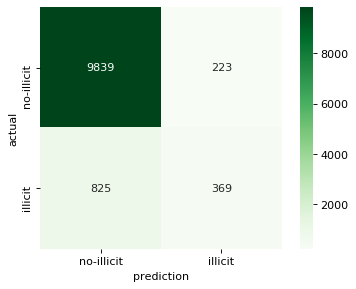

In [320]:
make_confusion_matrix(lr)

In [321]:
# Let's see how our confusion matrix changes with changes to the cutoff! 

from ipywidgets import interactive, FloatSlider

interactive(lambda threshold: make_confusion_matrix(lr, threshold), threshold=(0.0,1.0,0.02))

interactive(children=(FloatSlider(value=0.5, description='threshold', max=1.0, step=0.02), Output()), _dom_cla…

In [17]:
fpr, tpr, thresholds = roc_curve(y_test, lr.predict_proba(X_test)[:,1])

ROC AUC score =  0.8615467684942969


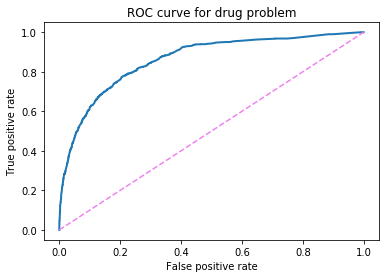

In [18]:
plt.plot(fpr, tpr,lw=2)
plt.plot([0,1],[0,1],c='violet',ls='--')
plt.xlim([-0.05,1.05])
plt.ylim([-0.05,1.05])


plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve for drug problem');
print("ROC AUC score = ", roc_auc_score(y_test, lr.predict_proba(X_test)[:,1]))

### Now we have a baseline model let's add some categorical features to run more complex models

In [19]:
#Separate our features from our target
X = df.drop(['ILLICIT','ID'], axis=1)

y = df['ILLICIT']

In [20]:
#Let's convert into categorical features into dummy variables

X = pd.get_dummies(X)

In [21]:
# Saving feature names for later use
feature_list = list(X.columns)

In [22]:
feature_list

['CIGS',
 'ALCOHOL',
 'MARIJUANA',
 'PAIN_REL',
 'OXYCONTIN',
 'TRANQUIL',
 'HEAVY_ALC',
 'ARMY',
 'PRIV_HEALTH',
 'HEALTH',
 'ARRESTED',
 'NERVOUS',
 'RESTLESS',
 'CIG_ALC_No Past Mon Use of Cig/Alc',
 'CIG_ALC_Past Mon Use of Alc & No Cig',
 'CIG_ALC_Past Mon Use of Cig & Alc',
 'CIG_ALC_Past Mon Use of Cig & No Alc',
 'GENDER_Female',
 'GENDER_Male',
 'MARITAL_Divorced or Separated',
 'MARITAL_Married',
 'MARITAL_Never Been Married',
 'MARITAL_Widowed',
 'AGE_12-17 Years Old',
 'AGE_18-25 Years Old',
 'AGE_26-34 Years Old',
 'AGE_35-49 Years Old',
 'AGE_50 or Older',
 'RACE_Hispanic',
 'RACE_NonHisp Asian',
 'RACE_NonHisp Black/Afr Am',
 'RACE_NonHisp White',
 'RACE_NonHisp more than one race',
 'EDUCATION_12 to 17 year olds',
 'EDUCATION_College graduate',
 'EDUCATION_High school grad',
 'EDUCATION_Less high school',
 'EDUCATION_Some coll/Assoc Dg',
 'EMPLOYMENT_12-14 year olds',
 'EMPLOYMENT_Employed full time',
 'EMPLOYMENT_Employed part time',
 'EMPLOYMENT_Other',
 'EMPLOYMENT_U

In [23]:
# hold out 20% of the data for final testing
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2, random_state=10)

In [24]:
print(X_train.shape, X_test.shape)

(45020, 50) (11256, 50)


In [25]:
print(y_train.shape, y_test.shape)

(45020,) (11256,)


## Model Selection using 10 folds Cross-Validation

### Logistic Regression again but with more features

In [26]:
#set up the baseline model:
lr = LogisticRegression() 

In [27]:
# One Pass
model = lr.fit(X_train, y_train)
acc = round(model.score(X_train, y_train) * 100, 2)
threshold = 0.5

In [28]:
# Cross Validation 
#with predict_proba
train_pred1 = model_selection.cross_val_predict(lr, 
                                                  X_train, 
                                                  y_train, 
                                                  cv=10, 
                                                  n_jobs = -1,
                                                  method='predict_proba')
#normal
train_pred2 = model_selection.cross_val_predict(lr, 
                                                  X_train, 
                                                  y_train, 
                                                  cv=10, 
                                                  n_jobs = -1,
                                               )

In [29]:
# Cross-validation accuracy metric
roc_cv = round(metrics.roc_auc_score(y_train, train_pred1[:,1]), 2)
acc_cv = round(metrics.accuracy_score(y_train, train_pred2), 2)
pre_cv = round(metrics.precision_score(y_train, train_pred2), 2)
rec_cv = round(metrics.recall_score(y_train, train_pred2), 2)
f1_cv = round(metrics.f1_score(y_train, train_pred2), 2)

ROC CV: 0.880
Accuracy CV: 0.910
Precision CV: 0.680
Recall CV: 0.350
F1 Score CV: 0.460


Text(93.77777777777786, 0.5, 'actual')

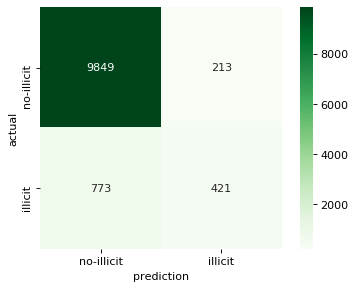

In [32]:
print(f'ROC CV: {roc_cv:.3f}')
print(f'Accuracy CV: {acc_cv:.3f}')
print(f'Precision CV: {pre_cv:.3f}')
print(f'Recall CV: {rec_cv:.3f}')
print(f'F1 Score CV: {f1_cv:.3f}')
    
y_predict = (model.predict_proba(X_test) >= threshold)
illicit_confusion = confusion_matrix(y_test, y_predict[:,1])
plt.figure(dpi=80)
sns.heatmap(illicit_confusion, cmap=plt.cm.Greens, annot=True, square=True, fmt='d',
xticklabels=['no-illicit', 'illicit'],
yticklabels=['no-illicit', 'illicit']);
plt.xlabel('prediction')
plt.ylabel('actual')

Let's define a function to fit machine learning algorithms
Since many of the algorithms we will use are from the sklearn library, they all take similar (practically the same) inputs and produce similar outputs.
To prevent writing code multiple times, we will functionise fitting the model and returning the ROC AUC scores.

In [46]:
# Function that runs the requested algorithm and returns the accuracy metrics
def fit_model(model_name, X_train, y_train, cv, threshold):
    
    # One Pass, fitting the model with the training set
    model = model_name.fit(X_train, y_train)
    acc = round(model.score(X_train, y_train) * 100, 2)
    
    # Cross Validation 
    train_pred = model_selection.cross_val_predict(model_name, 
                                                  X_train, 
                                                  y_train, 
                                                  cv=cv, 
                                                  n_jobs = -1)
    
     # Cross Validation 
    test_pred = model_selection.cross_val_predict(model_name, 
                                                  X_test, 
                                                  y_test, 
                                                  cv=cv, 
                                                  n_jobs = -1)
    
    # Cross-validation accuracy metric
    roc_cv = round(metrics.roc_auc_score(y_train, train_pred), 2)
    acc_cv = round(metrics.accuracy_score(y_train, train_pred), 2)
    pre_cv = round(metrics.precision_score(y_train, train_pred), 2)
    rec_cv = round(metrics.recall_score(y_train, train_pred), 2)
    f1_cv = round(metrics.f1_score(y_train, train_pred), 2)
   
    # Cross-validation accuracy metric
    roc_test = round(metrics.roc_auc_score(y_test, test_pred), 2)
    acc_test = round(metrics.accuracy_score(y_test, test_pred), 2)
    pre_test = round(metrics.precision_score(y_test, test_pred), 2)
    rec_test = round(metrics.recall_score(y_test, test_pred), 2)
    f1_test = round(metrics.f1_score(y_test, test_pred), 2)
    
    
    log_time = (time.time() - start_time)
    print ("Training Set")
    print(f'ROC CV: {roc_cv:.3f}')
    print(f'Accuracy CV: {acc_cv:.3f}')
    print(f'Precision CV: {pre_cv:.3f}')
    print(f'Recall CV: {rec_cv:.3f}')
    print(f'F1 Score CV: {f1_cv:.3f}')
    print("")
    print ("Testing Set")
    print(f'ROC test: {roc_test:.3f}')
    print(f'Accuracy test: {acc_test:.3f}')
    print(f'Precision test: {pre_test:.3f}')
    print(f'Recall test: {rec_test:.3f}')
    print(f'F1 Score test: {f1_test:.3f}')    
    print("")
    print("Running Time: %s" % datetime.timedelta(seconds=log_time))
    
    #Confusion Matrix
    y_predict = (model.predict(X_test) >= threshold)
    illicit_confusion = confusion_matrix(y_test, y_predict)
    plt.figure(dpi=80)
    sns.heatmap(illicit_confusion, cmap=plt.cm.Greens, annot=True, square=True, fmt='d',
    xticklabels=['no-illicit', 'illicit'],
    yticklabels=['no-illicit', 'illicit']);
    plt.xlabel('prediction')
    plt.ylabel('actual')

### Naive Bayes

Training Set
ROC CV: 0.750
Accuracy CV: 0.800
Precision CV: 0.320
Recall CV: 0.690
F1 Score CV: 0.430

Testing Set
ROC test: 0.750
Accuracy test: 0.800
Precision test: 0.310
Recall test: 0.680
F1 Score test: 0.420

Running Time: 0:00:01.314671


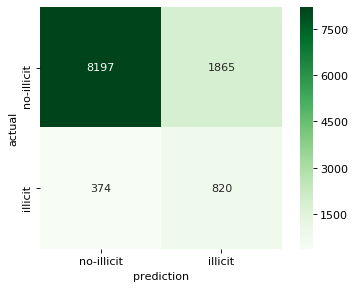

In [47]:
start_time = time.time()
fit_model(GaussianNB(), X_train, y_train, 10, 0.5)

### Linear Support Vector Machines (SVC)

In [40]:
#fit_model(LinearSVC(), X_train, y_train, 10,0.5) 

### DecisionTreeClassifier

Training Set
ROC CV: 0.660
Accuracy CV: 0.860
Precision CV: 0.390
Recall CV: 0.410
F1 Score CV: 0.400

Testing Set
ROC test: 0.640
Accuracy test: 0.860
Precision test: 0.350
Recall test: 0.370
F1 Score test: 0.360

Running Time: 0:02:16.160990


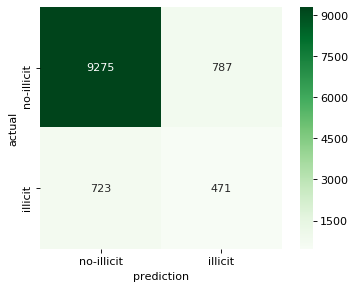

In [41]:
fit_model(DecisionTreeClassifier(), X_train, y_train, 10,0.5) 

### GradientBoostingClassifier

Training Set
ROC CV: 0.660
Accuracy CV: 0.910
Precision CV: 0.710
Recall CV: 0.340
F1 Score CV: 0.460

Testing Set
ROC test: 0.660
Accuracy test: 0.910
Precision test: 0.660
Recall test: 0.330
F1 Score test: 0.440

Running Time: 0:02:08.345450


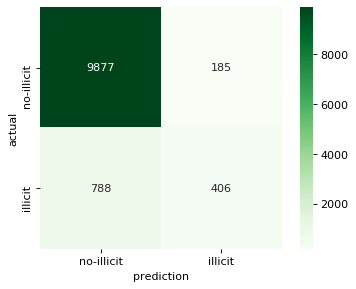

In [48]:
fit_model(GradientBoostingClassifier(), X_train, y_train, 10,0.5) 

### KNeighborsClassifier

In [ ]:
#fit_model(KNeighborsClassifier(), X_train, y_train, 10,0.5) 

### RandomForestClassifier

Training Set
ROC CV: 0.630
Accuracy CV: 0.900
Precision CV: 0.610
Recall CV: 0.290
F1 Score CV: 0.390

Testing Set
ROC test: 0.610
Accuracy test: 0.900
Precision test: 0.570
Recall test: 0.250
F1 Score test: 0.340

Running Time: 0:00:04.801800


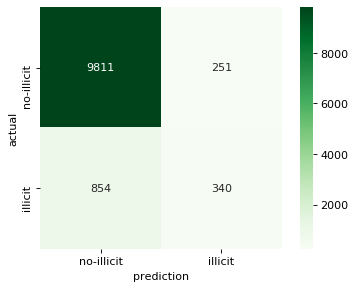

In [52]:
start_time = time.time()
fit_model(RandomForestClassifier(), X_train, y_train, 10,0.5) 

Let's run Random Forest again to use it as a feature engineering tool

In [53]:
# Instantiate model with 50 decision trees
rf = RandomForestClassifier(n_estimators = 50, random_state = 42)

In [54]:
acc = round(model.score(X_train, y_train) * 100, 2)
threshold = 0.5

# Train the model on training data
train_pred = rf.fit(X_train,y_train)

# Cross Validation 
#with predict_proba
train_pred = model_selection.cross_val_predict(rf, 
                                                  X_train, 
                                                  y_train, 
                                                  cv=10, 
                                                  n_jobs = -1,
                                                  )
# Cross-validation accuracy metric
roc_cv = round(metrics.roc_auc_score(y_train, train_pred), 2)
acc_cv = round(metrics.accuracy_score(y_train, train_pred), 2)
pre_cv = round(metrics.precision_score(y_train, train_pred), 2)
rec_cv = round(metrics.recall_score(y_train, train_pred), 2)
f1_cv = round(metrics.f1_score(y_train, train_pred), 2)
   
print ("Training Set")
print(f'ROC CV: {roc_cv:.3f}')
print(f'Accuracy CV: {acc_cv:.3f}')
print(f'Precision CV: {pre_cv:.3f}')
print(f'Recall CV: {rec_cv:.3f}')
print(f'F1 Score CV: {f1_cv:.3f}')
print("")


Training Set
ROC CV: 0.650
Accuracy CV: 0.900
Precision CV: 0.650
Recall CV: 0.310
F1 Score CV: 0.420



In [55]:
# Get numerical feature importances
importances = list(rf.feature_importances_)
# List of tuples with variable and importance
feature_importances = [(feature, round(importance, 2)) for feature, importance in zip(feature_list, importances)]
# Sort the feature importances by most important first
feature_importances = sorted(feature_importances, key = lambda x: x[1], reverse = True)
# Print out the feature and importances 
[print('{:20} Importance: {}'.format(*pair)) for pair in feature_importances];

Variable: MARIJUANA            Importance: 0.1
Variable: TRANQUIL             Importance: 0.06
Variable: PAIN_REL             Importance: 0.05
Variable: NERVOUS              Importance: 0.05
Variable: RESTLESS             Importance: 0.05
Variable: CIGS                 Importance: 0.03
Variable: PRIV_HEALTH          Importance: 0.03
Variable: ALCOHOL              Importance: 0.02
Variable: OXYCONTIN            Importance: 0.02
Variable: HEAVY_ALC            Importance: 0.02
Variable: ARRESTED             Importance: 0.02
Variable: CIG_ALC_Past Mon Use of Cig & Alc Importance: 0.02
Variable: GENDER_Female        Importance: 0.02
Variable: GENDER_Male          Importance: 0.02
Variable: MARITAL_Never Been Married Importance: 0.02
Variable: AGE_18-25 Years Old  Importance: 0.02
Variable: RACE_Hispanic        Importance: 0.02
Variable: RACE_NonHisp White   Importance: 0.02
Variable: EDUCATION_High school grad Importance: 0.02
Variable: EDUCATION_Some coll/Assoc Dg Importance: 0.02
Variable

To reduce complexity of future models the 5 least important features as show in the random forest classification model will be excluded

In [56]:
X_train = X_train.drop(['EMPLOYMENT_Unemployed','MARITAL_Widowed','AGE_12-17 Years Old',
                        'EDUCATION_12 to 17 year olds','EMPLOYMENT_12-14 year olds'],axis = 1)

In [57]:
X_test = X_test.drop(['EMPLOYMENT_Unemployed','MARITAL_Widowed','AGE_12-17 Years Old',
                        'EDUCATION_12 to 17 year olds','EMPLOYMENT_12-14 year olds'],axis = 1)

In [58]:
print(X_train.shape, X_test.shape)

(45020, 45) (11256, 45)


In [ ]:
# Let's create a three to understand most important estimators, while limit depth of tree to 3 levels
rf_small = RandomForestClassifier(n_estimators=10, max_depth = 4)
rf_small.fit(X_train, y_train)
# Extract the small tree
tree_small = rf_small.estimators_[5]

# Save the tree as a png image
export_graphviz(tree_small, out_file = 'small_tree.dot',
feature_names = feature_list, rounded = True, precision = 1)

(graph, ) = pydot.graph_from_dot_file('small_tree.dot')

graph.write_png('small_tree.png');

In [61]:
%%html
<img src="small_tree.png",width=120,height=120>

Conclusion: After running all these models the logistic regression and naive bayes were the ones with the highest scores so we will tune them to increase predictability.

### Let's fix the target imbalance issue before tuning our best models  

In [62]:
# Now add some random oversampling of the minority classes
ros = RandomOverSampler(random_state=0)
X_resampled, y_resampled = ros.fit_sample(X_train,y_train)

In [63]:
print(X_resampled.shape, y_resampled.shape)

(79936, 45) (79936,)


In [64]:
# Yay, balanced classes!
Counter(y_resampled)

Counter({0: 39968, 1: 39968})

In [65]:
#set up the baseline model:
lr = LogisticRegression() 

In [66]:
#fit
lr.fit(X_resampled, y_resampled)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)

In [67]:
print("ROC train score: {:6.4f}".format(roc_auc_score(y_resampled,lr.predict_proba(X_resampled)[:,1])))


ROC train score: 0.8805


In [68]:
print("Precision train score: {:6.4f}".format(precision_score(y_resampled,lr.predict(X_resampled))))
print("Recall train score: {:6.4f}".format(recall_score(y_resampled,lr.predict(X_resampled))))
print("F1 train score: {:6.4f}".format(f1_score(y_resampled,lr.predict(X_resampled))))

Precision train score: 0.8016
Recall train score: 0.7824
F1 train score: 0.7919


Text(93.77777777777786, 0.5, 'actual')

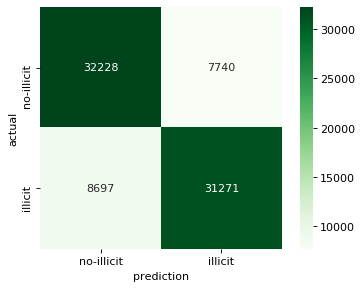

In [69]:
threshold = 0.5
y_predict = (lr.predict(X_resampled) >= threshold)
illicit_confusion = confusion_matrix(y_resampled, y_predict)
plt.figure(dpi=80)
sns.heatmap(illicit_confusion, cmap=plt.cm.Greens, annot=True, square=True, fmt='d',
xticklabels=['no-illicit', 'illicit'],
yticklabels=['no-illicit', 'illicit']);
plt.xlabel('prediction')
plt.ylabel('actual')

In [ ]:
#Let's score the model with the testing dataset 
print("ROC train score: {:6.4f}".format(roc_auc_score(y_train,lr.predict_proba(X_train)[:,1])))
print("ROC test score: {:6.4f}".format(roc_auc_score(y_test,lr.predict_proba(X_test)[:,1])))
print("Precision test score: {:6.4f}".format(precision_score(y_test,lr.predict(X_test))))
print("Recall test score: {:6.4f}".format(recall_score(y_test,lr.predict(X_test))))
print("F1 test score: {:6.4f}".format(f1_score(y_test,lr.predict(X_test))))

Text(93.77777777777786, 0.5, 'actual')

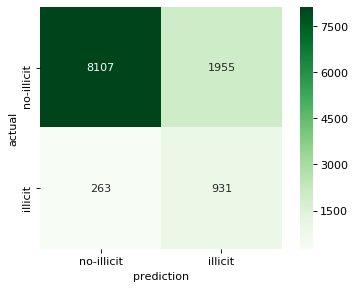

In [71]:
threshold = 0.5
y_predict = (lr.predict(X_test) >= threshold)
illicit_confusion = confusion_matrix(y_test, y_predict)
plt.figure(dpi=80)
sns.heatmap(illicit_confusion, cmap=plt.cm.Greens, annot=True, square=True, fmt='d',
xticklabels=['no-illicit', 'illicit'],
yticklabels=['no-illicit', 'illicit']);
plt.xlabel('prediction')
plt.ylabel('actual')

In [72]:
#set up the baseline model:
nb = GaussianNB()

In [73]:
#fit
nb.fit(X_resampled, y_resampled)

GaussianNB(priors=None, var_smoothing=1e-09)

In [74]:
print("ROC train score: {:6.4f}".format(roc_auc_score(y_resampled,nb.predict(X_resampled))))

ROC train score: 0.7631


In [75]:
#Let's score the model with the testing dataset 
print("ROC test score: {:6.4f}".format(roc_auc_score(y_test,nb.predict(X_test))))
print("Precision test score: {:6.4f}".format(precision_score(y_test,nb.predict(X_test))))
print("Recall test score: {:6.4f}".format(recall_score(y_test,nb.predict(X_test))))
print("F1 test score: {:6.4f}".format(f1_score(y_test,nb.predict(X_test))))

ROC test score: 0.7601
Precision test score: 0.2927
Recall test score: 0.7295
F1 test score: 0.4177


### Let's create a model excluding observations of young people 

In [7]:
df2= df[df['AGE']!='12-17 Years Old']

In [8]:
#Separate our features from our target
X2 = df2.drop(['ILLICIT','ID'], axis=1)

y2 = df2['ILLICIT']

In [9]:
#Let's convert into categorical features into dummy variables

X2 = pd.get_dummies(X2)

In [10]:
# hold out 20% of the data for final testing
X2_train, X2_test, y2_train, y2_test = train_test_split(X2, y2, test_size=.2, random_state=10)

In [11]:
print(X2_train.shape,X2_test.shape)

(34043, 47) (8511, 47)


In [12]:
feature_list2 = list(X2_train.columns)

In [13]:
#set up the baseline model:
lr = LogisticRegression() 

In [162]:
#fit
lr.fit(X2_train, y2_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)

In [166]:
print("ROC train score: {:6.4f}".format(roc_auc_score(y2_train,lr.predict_proba(X2_train)[:,1])))
print("ROC test score: {:6.4f}".format(roc_auc_score(y2_test,lr.predict_proba(X2_test)[:,1])))

ROC train score: 0.8829
ROC test score: 0.8712


In [167]:
print("Precision test score: {:6.4f}".format(precision_score(y2_test,lr.predict(X2_test))))
print("Recall test score: {:6.4f}".format(recall_score(y2_test,lr.predict(X2_test))))
print("F1 test score: {:6.4f}".format(f1_score(y2_test,lr.predict(X2_test))))

Precision test score: 0.6761
Recall test score: 0.3507
F1 test score: 0.4618


In [251]:
# Now add some random oversampling of the minority class
ros = RandomOverSampler(random_state=0)
X_resampled, y_resampled = ros.fit_sample(X2_train,y2_train)

In [169]:
print(X_resampled.shape, y_resampled.shape)

(59868, 47) (59868,)


In [170]:
#set up the baseline model:
lr = LogisticRegression() 

In [171]:
#fit
lr.fit(X_resampled, y_resampled)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)

In [174]:
print("ROC train score: {:6.4f}".format(roc_auc_score(y2_train,lr.predict_proba(X2_train)[:,1])))
print("ROC test score: {:6.4f}".format(roc_auc_score(y2_test,lr.predict_proba(X2_test)[:,1])))

ROC train score: 0.8839
ROC test score: 0.8725


In [175]:
print("Accuracy test score: {:6.4f}".format(accuracy_score(y2_test,lr.predict(X2_test))))
print("Precision test score: {:6.4f}".format(precision_score(y2_test,lr.predict(X2_test))))
print("Recall test score: {:6.4f}".format(recall_score(y2_test,lr.predict(X2_test))))
print("F1 test score: {:6.4f}".format(f1_score(y2_test,lr.predict(X2_test))))

Accuracy test score: 0.7987
Precision test score: 0.3460
Recall test score: 0.7672
F1 test score: 0.4769


Text(93.77777777777786, 0.5, 'actual')

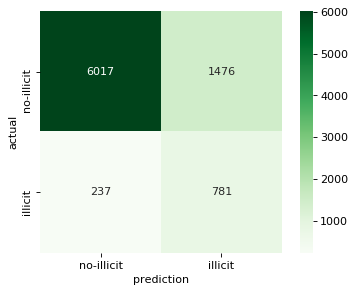

In [176]:
threshold = 0.5
y_predict = (lr.predict(X2_test) >= threshold)
illicit_confusion = confusion_matrix(y2_test, y_predict)
plt.figure(dpi=80)
sns.heatmap(illicit_confusion, cmap=plt.cm.Greens, annot=True, square=True, fmt='d',
xticklabels=['no-illicit', 'illicit'],
yticklabels=['no-illicit', 'illicit']);
plt.xlabel('prediction')
plt.ylabel('actual')

In [92]:
#set up the baseline model:
rf = RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features=6, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=10,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [93]:
#fit
rf.fit(X_resampled, y_resampled)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features=6, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=10,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [94]:
print("ROC test score: {:6.4f}".format(roc_auc_score(y2_test,rf.predict(X2_test))))

ROC test score: 0.6681


In [95]:
#Let's score the model with the testing dataset 
print("ROC test score: {:6.4f}".format(roc_auc_score(y2_test,rf.predict(X2_test))))
print("Precision test score: {:6.4f}".format(precision_score(y2_test,rf.predict(X2_test))))
print("Recall test score: {:6.4f}".format(recall_score(y2_test,rf.predict(X2_test))))
print("F1 test score: {:6.4f}".format(f1_score(y2_test,rf.predict(X2_test))))

ROC test score: 0.6681
Precision test score: 0.5397
Recall test score: 0.3802
F1 test score: 0.4461


In [189]:
# Test with pipeline and gridsearchcv

from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV

# Create first pipeline for base without reducing features.

pipe = Pipeline([('classifier' , LogisticRegression())])
# pipe = Pipeline([('classifier', RandomForestClassifier())])

# Create param grid.

param_grid = [
    {'classifier' : [LogisticRegression()],
     'classifier__penalty' : ['l1', 'l2'],
    'classifier__C' : np.logspace(-4, 4, 20),
    'classifier__solver' : ['liblinear']},
    #{'classifier' : [RandomForestClassifier()],
    #'classifier__n_estimators' : list(range(10,101,10)),
    #'classifier__max_features' : list(range(6,34,3))}
]

# Create grid search object

clf = GridSearchCV(pipe, param_grid = param_grid, cv = 5, verbose=True)


# Fit on data

best_clf = clf.fit(X_resampled, y_resampled)

Fitting 5 folds for each of 40 candidates, totalling 200 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:  5.5min finished


In [190]:
best_clf.best_estimator_.get_params()['classifier']

LogisticRegression(C=3792.690190732246, class_weight=None, dual=False,
                   fit_intercept=True, intercept_scaling=1, l1_ratio=None,
                   max_iter=100, multi_class='warn', n_jobs=None, penalty='l1',
                   random_state=None, solver='liblinear', tol=0.0001, verbose=0,
                   warm_start=False)

In [191]:
#set up the baseline model:
lr = LogisticRegression(C=3792.690190732246, class_weight=None, dual=False,
                   fit_intercept=True, intercept_scaling=1, l1_ratio=None,
                   max_iter=100, multi_class='warn', n_jobs=None, penalty='l1',
                   random_state=None, solver='liblinear', tol=0.0001, verbose=0,
                   warm_start=False) 

In [192]:
#fit
lr.fit(X_resampled, y_resampled)

LogisticRegression(C=3792.690190732246, class_weight=None, dual=False,
                   fit_intercept=True, intercept_scaling=1, l1_ratio=None,
                   max_iter=100, multi_class='warn', n_jobs=None, penalty='l1',
                   random_state=None, solver='liblinear', tol=0.0001, verbose=0,
                   warm_start=False)

In [197]:
print("ROC train score: {:6.4f}".format(roc_auc_score(y2_train,lr.predict_proba(X2_train)[:,1])))
print("ROC test score: {:6.4f}".format(roc_auc_score(y2_test,lr.predict_proba(X2_test)[:,1])))

ROC train score: 0.8839
ROC test score: 0.8725


In [194]:
print("Accuracy test score: {:6.4f}".format(accuracy_score(y2_test,lr.predict(X2_test))))
print("Precision test score: {:6.4f}".format(precision_score(y2_test,lr.predict(X2_test))))
print("Recall test score: {:6.4f}".format(recall_score(y2_test,lr.predict(X2_test))))
print("F1 test score: {:6.4f}".format(f1_score(y2_test,lr.predict(X2_test))))

Accuracy test score: 0.7987
Precision test score: 0.3460
Recall test score: 0.7672
F1 test score: 0.4769


In [196]:
pd.DataFrame(zip(feature_list2,*lr.coef_),columns =['Features','Coefficients']).\
            sort_values(by="Coefficients",ascending=False).reset_index(drop=True)

,Features,Coefficients
0,MARIJUANA,1.620372
1,PAIN_REL,1.469625
2,TRANQUIL,1.247808
3,HEAVY_ALC,0.698876
4,CIGS,0.652795
5,OXYCONTIN,0.590912
6,RESTLESS,0.563659
7,ARRESTED,0.457027
8,ALCOHOL,0.267470
9,NERVOUS,0.194680


## Model Complexity Reduction

### Let's create a simplified model to use in our flask app

In [14]:
#Let's create a model with the 10 most predictive featurex
X3 = X2[['MARIJUANA','PAIN_REL','TRANQUIL','CIGS','OXYCONTIN','HEAVY_ALC',
        'EDUCATION_High school grad','EDUCATION_Less high school','AGE_35-49 Years Old',
         'AGE_50 or Older','MARITAL_Married']]

y3 = y2.copy()

In [15]:
X3.columns

Index(['MARIJUANA', 'PAIN_REL', 'TRANQUIL', 'CIGS', 'OXYCONTIN', 'HEAVY_ALC',
       'EDUCATION_High school grad', 'EDUCATION_Less high school',
       'AGE_35-49 Years Old', 'AGE_50 or Older', 'MARITAL_Married'],
      dtype='object')

In [16]:
y3.shape

(42554,)

In [17]:
# hold out 20% of the data for final testing
X3_train, X3_test, y3_train, y3_test = train_test_split(X3, y3, test_size=.2, random_state=10)

In [18]:
feature_list3 = list(X3_train.columns)

In [19]:
# Now add some random oversampling of the minority class
ros = RandomOverSampler(random_state=0)
X_resampled, y_resampled = ros.fit_sample(X3_train,y3_train)

In [303]:
# Test with pipeline and gridsearchcv

from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV

# Create first pipeline for base without reducing features.

pipe = Pipeline([('classifier' , LogisticRegression())])
# pipe = Pipeline([('classifier', RandomForestClassifier())])

# Create param grid.

param_grid = [
    {'classifier' : [LogisticRegression()],
     'classifier__penalty' : ['l1', 'l2'],
    'classifier__C' : np.logspace(-4, 4, 20),
    'classifier__solver' : ['liblinear']},
    #{'classifier' : [RandomForestClassifier()],
    #'classifier__n_estimators' : list(range(10,101,10)),
    #'classifier__max_features' : list(range(6,34,3))}
]

# Create grid search object

clf = GridSearchCV(pipe, param_grid = param_grid, cv = 3, verbose=True)


# Fit on data

best_clf = clf.fit(X_resampled, y_resampled)

Fitting 3 folds for each of 40 candidates, totalling 120 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 120 out of 120 | elapsed:    9.8s finished


In [304]:
best_clf.best_estimator_.get_params()['classifier']

LogisticRegression(C=0.004832930238571752, class_weight=None, dual=False,
                   fit_intercept=True, intercept_scaling=1, l1_ratio=None,
                   max_iter=100, multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='liblinear', tol=0.0001, verbose=0,
                   warm_start=False)

In [20]:
#set up the baseline model:
lr = LogisticRegression(C=0.004832930238571752, class_weight=None, dual=False,
                   fit_intercept=True, intercept_scaling=1, l1_ratio=None,
                   max_iter=100, multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='liblinear', tol=0.0001, verbose=0,
                   warm_start=False) 

In [21]:
#fit
lr.fit(X_resampled, y_resampled)

LogisticRegression(C=0.004832930238571752, class_weight=None, dual=False,
                   fit_intercept=True, intercept_scaling=1, l1_ratio=None,
                   max_iter=100, multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='liblinear', tol=0.0001, verbose=0,
                   warm_start=False)

In [22]:
print("ROC train score: {:6.4f}".format(roc_auc_score(y3_train,lr.predict_proba(X3_train)[:,1])))
print("ROC test score: {:6.4f}".format(roc_auc_score(y3_test,lr.predict_proba(X3_test)[:,1])))

ROC train score: 0.8769
ROC test score: 0.8647


In [23]:
print("Accuracy test score: {:6.4f}".format(accuracy_score(y3_test,lr.predict(X3_test))))
print("Precision test score: {:6.4f}".format(precision_score(y3_test,lr.predict(X3_test))))
print("Recall test score: {:6.4f}".format(recall_score(y3_test,lr.predict(X3_test))))
print("F1 test score: {:6.4f}".format(f1_score(y3_test,lr.predict(X3_test))))

Accuracy test score: 0.7866
Precision test score: 0.3306
Recall test score: 0.7652
F1 test score: 0.4618


In [24]:
pd.DataFrame(zip(feature_list3,*lr.coef_),columns =['Features','Coefficients(log)']).\
            sort_values(by="Coefficients(log)",ascending=False).reset_index(drop=True)

,Features,Coefficients(log)
0,MARIJUANA,1.596268
1,PAIN_REL,1.225663
2,TRANQUIL,1.115329
3,HEAVY_ALC,0.687944
4,CIGS,0.659599
5,OXYCONTIN,0.498166
6,EDUCATION_High school grad,-0.240126
7,EDUCATION_Less high school,-0.248111
8,AGE_35-49 Years Old,-0.397433
9,MARITAL_Married,-0.535005


In [25]:
feature_list3

['MARIJUANA',
 'PAIN_REL',
 'TRANQUIL',
 'CIGS',
 'OXYCONTIN',
 'HEAVY_ALC',
 'EDUCATION_High school grad',
 'EDUCATION_Less high school',
 'AGE_35-49 Years Old',
 'AGE_50 or Older',
 'MARITAL_Married']

In [26]:
feature_list3 = ['MARIJUANA','PAIN_REL','TRANQUIL','CIGS','OXYCONTIN','HEAVY_ALC','HIGH SCHOOL',
 '<HIGH SCHOOL','AGE_35-49','AGE_50','MARRIED']

In [27]:
coefficients3 = pd.DataFrame(zip(feature_list3,*np.exp(lr.coef_)),columns =['Features','Coefficients (exp-odds)']).\
            sort_values(by="Coefficients (exp-odds)",ascending=False).reset_index(drop=True)

In [28]:
coefficients3

,Features,Coefficients (exp-odds)
0,MARIJUANA,4.934583
1,PAIN_REL,3.406422
2,TRANQUIL,3.050572
3,HEAVY_ALC,1.989622
4,CIGS,1.934017
5,OXYCONTIN,1.645700
6,HIGH SCHOOL,0.786529
7,<HIGH SCHOOL,0.780274
8,AGE_35-49,0.672043
9,MARRIED,0.585666


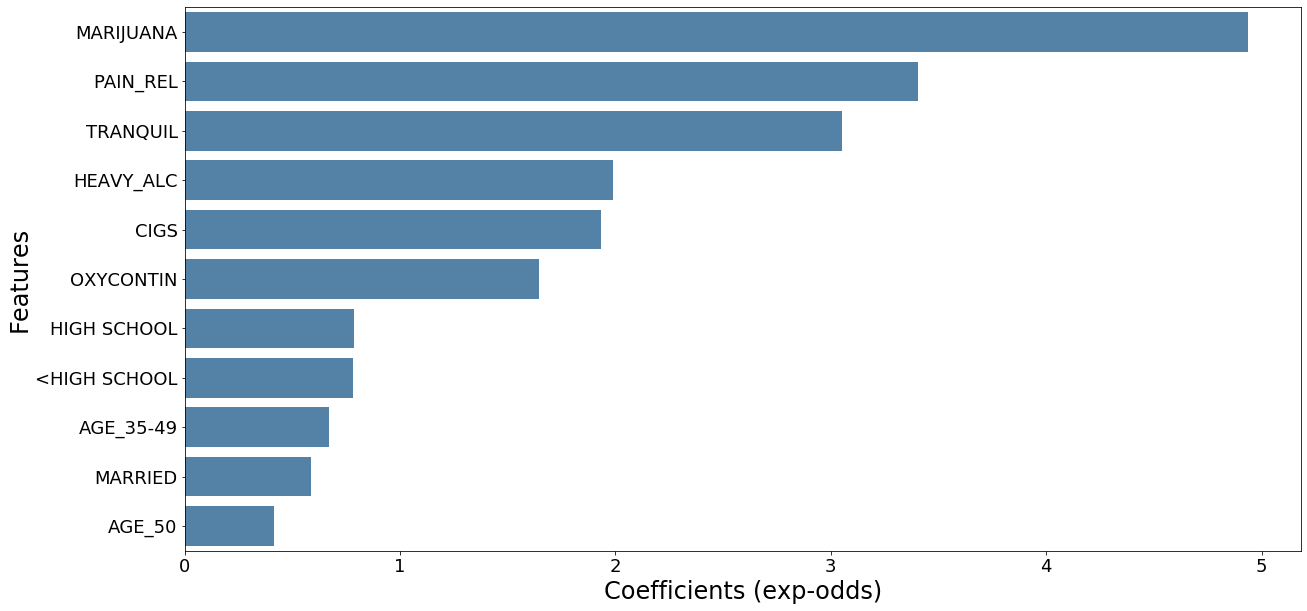

In [34]:
fig = plt.figure(figsize=(20,10))
coeff = sns.barplot(x = 'Coefficients (exp-odds)',y='Features',data=coefficients3, color='steelblue')
SMALL_SIZE = 8
MEDIUM_SIZE = 22
BIGGER_SIZE = 24
plt.rc('font', size=MEDIUM_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=BIGGER_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=BIGGER_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=MEDIUM_SIZE)    # legend fontsize
plt.rc('figure', titlesize=MEDIUM_SIZE)

Conclusion: For a person who consumes Marijuana, the odds of consuming illegal drugs is fives times higher than those who don't, holding everything else constant.

In [99]:
def make_confusion_matrix(model, threshold=0.5):
    # Predict class 1 if probability of being in class 1 is greater than threshold
    # (model.predict(X_test) does this automatically with a threshold of 0.5)
    y_predict = (model.predict_proba(X3_test)[:, 1] >= threshold)
    illicit_confusion = confusion_matrix(y3_test, y_predict)
    plt.figure(dpi=80)
    sns.heatmap(illicit_confusion, cmap=plt.cm.Greens, annot=True, square=True, fmt='d',
           xticklabels=['no-illicit', 'illicit'],
           yticklabels=['no-illicit', 'illicit']);
    plt.xlabel('prediction')
    plt.ylabel('actual')

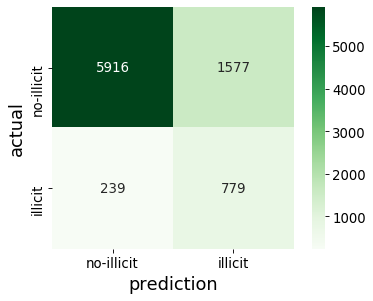

In [101]:
confusion_matrix = make_confusion_matrix(lr, threshold=0.5)

In [100]:
# Let's see how our confusion matrix changes with changes to the cutoff! 

from ipywidgets import interactive, FloatSlider

interactive(lambda threshold: make_confusion_matrix(lr, threshold), threshold=(0.0,1.0,0.02))

interactive(children=(FloatSlider(value=0.5, description='threshold', max=1.0, step=0.02), Output()), _dom_cla…

In [381]:
threshold = 0.5
y_predict = np.where(lr.predict_proba(X3_test)[:,1] > threshold, 1, 0)

pd.DataFrame(data=[accuracy_score(y3_test, y_predict), recall_score(y3_test, y_predict),
                   precision_score(y3_test, y_predict), roc_auc_score(y3_test, y_predict)], 
             index=["accuracy", "recall", "precision", "roc_auc_score"])

,0
accuracy,0.757608
recall,0.803536
precision,0.305110
roc_auc_score,0.777452


In [383]:
#pickle for flask
pickle.dump(lr, open('my_pickled_model.p','wb'))

In [102]:
#Let's create a model without Marijauan
X4 = X3[['PAIN_REL','TRANQUIL','CIGS','OXYCONTIN','HEAVY_ALC',
        'EDUCATION_High school grad','EDUCATION_Less high school','AGE_35-49 Years Old',
         'AGE_50 or Older','MARITAL_Married']]

y4 = y3.copy()

In [103]:
X4.columns

Index(['PAIN_REL', 'TRANQUIL', 'CIGS', 'OXYCONTIN', 'HEAVY_ALC',
       'EDUCATION_High school grad', 'EDUCATION_Less high school',
       'AGE_35-49 Years Old', 'AGE_50 or Older', 'MARITAL_Married'],
      dtype='object')

In [104]:
y4.shape

(42554,)

In [105]:
# hold out 20% of the data for final testing
X4_train, X4_test, y4_train, y4_test = train_test_split(X4, y4, test_size=.2, random_state=10)

In [106]:
feature_list4 = list(X4_train.columns)

In [107]:
# Now add some random oversampling of the minority class
ros = RandomOverSampler(random_state=0)
X_resampled, y_resampled = ros.fit_sample(X4_train,y4_train)

In [108]:
#set up the baseline model:
lr = LogisticRegression(C=0.004832930238571752, class_weight=None, dual=False,
                   fit_intercept=True, intercept_scaling=1, l1_ratio=None,
                   max_iter=100, multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='liblinear', tol=0.0001, verbose=0,
                   warm_start=False) 

In [109]:
#fit
lr.fit(X_resampled, y_resampled)

LogisticRegression(C=0.004832930238571752, class_weight=None, dual=False,
                   fit_intercept=True, intercept_scaling=1, l1_ratio=None,
                   max_iter=100, multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='liblinear', tol=0.0001, verbose=0,
                   warm_start=False)

In [110]:
print("ROC train score: {:6.4f}".format(roc_auc_score(y4_train,lr.predict_proba(X4_train)[:,1])))
print("ROC test score: {:6.4f}".format(roc_auc_score(y4_test,lr.predict_proba(X4_test)[:,1])))

ROC train score: 0.8401
ROC test score: 0.8242


In [111]:
print("Accuracy test score: {:6.4f}".format(accuracy_score(y4_test,lr.predict(X4_test))))
print("Precision test score: {:6.4f}".format(precision_score(y4_test,lr.predict(X4_test))))
print("Recall test score: {:6.4f}".format(recall_score(y4_test,lr.predict(X4_test))))
print("F1 test score: {:6.4f}".format(f1_score(y4_test,lr.predict(X4_test))))

Accuracy test score: 0.7607
Precision test score: 0.2940
Recall test score: 0.7141
F1 test score: 0.4165


In [112]:
pd.DataFrame(zip(feature_list4,*np.exp(lr.coef_)),columns =['Features','Coefficients (exp-odds)']).\
            sort_values(by="Coefficients (exp-odds)",ascending=False).reset_index(drop=True)

,Features,Coefficients (exp-odds)
0,TRANQUIL,3.459363
1,PAIN_REL,3.261853
2,CIGS,2.631281
3,HEAVY_ALC,2.489052
4,OXYCONTIN,1.716594
5,EDUCATION_High school grad,0.767958
6,EDUCATION_Less high school,0.742968
7,AGE_35-49 Years Old,0.555371
8,MARITAL_Married,0.482302
9,AGE_50 or Older,0.316870


In [114]:
def make_confusion_matrix(model, threshold=0.5):
    # Predict class 1 if probability of being in class 1 is greater than threshold
    # (model.predict(X_test) does this automatically with a threshold of 0.5)
    y_predict = (model.predict_proba(X4_test)[:, 1] >= threshold)
    illicit_confusion = confusion_matrix(y4_test, y_predict)
    plt.figure(dpi=80)
    sns.heatmap(illicit_confusion, cmap=plt.cm.Greens, annot=True, square=True, fmt='d',
           xticklabels=['no-illicit', 'illicit'],
           yticklabels=['no-illicit', 'illicit']);
    plt.xlabel('prediction')
    plt.ylabel('actual')

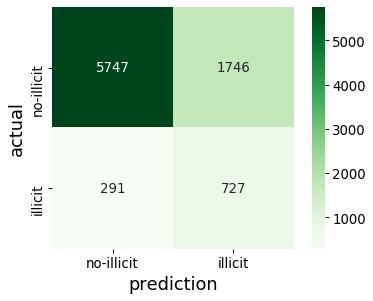

In [115]:
confusion_matrix = make_confusion_matrix(lr, threshold=0.5)

In [26]:
#pickle for flask
pickle.dump(lr, open('my_pickled_model.p','wb'))